# Make Money with Machine Learning
Week 2: Homework Assignment (**Stock Prediction**)

In [0]:
# First, we'll setup shop.

import math
import pandas as pd
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

mpl.rc('figure', figsize=(8, 7))
style.use('ggplot')

print("Good to go.")

Good to go.


In [0]:
# Now, lets get some data.

def get_historical_data(symbol, start_date="2019-01-01"):
  yf.pdr_override()
  df = pdr.get_data_yahoo(symbol, start=start_date).reset_index()
  df.to_csv(symbol + '.csv', index=False)
  
get_historical_data('SHOP')

print("Data acquired!")

[*********************100%***********************]  1 of 1 downloaded
Data acquired!


![DATA](https://i.imgur.com/TYIPIY3.gif "Data!")

In [0]:
print("I'm not sure if this is a good idea...");
print("But, we're going to interpolate the weekend. 🤷");

df = pd.read_csv('SHOP.csv');
df = df.loc[:, ['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Adj Close']]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by=['Date'], ascending=[True])
df.set_index('Date', inplace=True)
df = df.resample('D').fillna(method=None).interpolate()

df.head()

I'm not sure if this is a good idea, but, we're going to interpolate the weekend. 🤷


,Volume,Open,High,Low,Close,Adj Close
Date,,,,,,
2019-01-02,1.232600e+06,134.000000,139.139999,131.169998,137.600006,137.600006
2019-01-03,1.219500e+06,134.759995,136.259995,129.479996,129.789993,129.789993
2019-01-04,1.366100e+06,134.509995,139.500000,133.160004,138.059998,138.059998
2019-01-05,1.330733e+06,136.223328,141.616669,135.020004,140.169998,140.169998
2019-01-06,1.295367e+06,137.936661,143.733337,136.880005,142.279999,142.279999


Next, we'll calculate the price changes for some feature engineering fun.


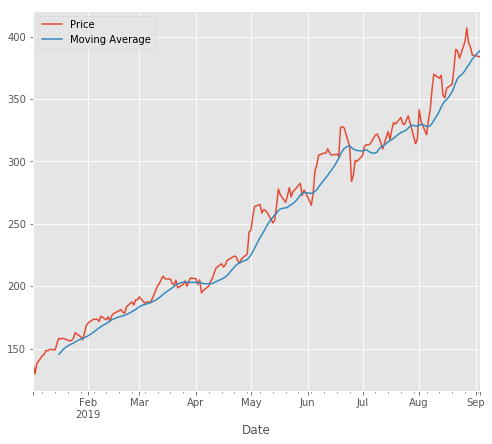

In [0]:
print("Next, we'll calculate the price changes to engineer extra features.")

# Calculate moving average
ma_window = 15
df['MA'] = df['Adj Close'].rolling(window=ma_window).mean()
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

df['Adj Close'].plot(label='Price')
df['MA'].plot(label='Moving Average')
plt.legend()

In [0]:
# Now, it's time for preprocessing & cross-validation!

# Drop missing value
df.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(df)))

# Separating the label here, we want to predict the Forecast value
df['Label'] = df['Adj Close'].shift(-forecast_out)
X = np.array(df.drop(['Label'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(df['Label'])
y = y[:-forecast_out]

df.head()

,Volume,Open,High,Low,Close,Adj Close,MA,HL_PCT,PCT_change,Label
Date,,,,,,,,,,
2019-01-02,1.232600e+06,134.000000,139.139999,131.169998,137.600006,137.600006,-99999.0,5.792152,2.686572,140.169998
2019-01-03,1.219500e+06,134.759995,136.259995,129.479996,129.789993,129.789993,-99999.0,5.223823,-3.688040,142.279999
2019-01-04,1.366100e+06,134.509995,139.500000,133.160004,138.059998,138.059998,-99999.0,4.592203,2.639211,144.389999
2019-01-05,1.330733e+06,136.223328,141.616669,135.020004,140.169998,140.169998,-99999.0,4.706188,2.897206,145.440002
2019-01-06,1.295367e+06,137.936661,143.733337,136.880005,142.279999,142.279999,-99999.0,4.816793,3.148791,148.619995


In [0]:
# So, how'd we do?

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)
clfreg_confidence = clfreg.score(X, y) * 100
print('Linear regression score: {:.2f}%'.format(clfreg_confidence))

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)
clfpoly2_confidence = clfpoly2.score(X, y) * 100
print('Quadratic Regression 2 score: {:.2f}%'.format(clfpoly2_confidence))

# Quadratic Regression 5
clfpoly5 = make_pipeline(PolynomialFeatures(5), Ridge())
clfpoly5.fit(X, y)
clfpoly5_confidence = clfpoly5.score(X, y) * 100
print('Quadratic Regression 5 score: {:.2f}%'.format(clfpoly5_confidence))

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)
clfknn_confidence = clfknn.score(X, y) * 100
print('KNN Regression score: {:.2f}%'.format(clfknn_confidence))

Linear regression score: 98.19%
Quadratic Regression 2 score: 98.31%
Quadratic Regression 5 score: 99.17%
KNN Regression score: 98.47%


Let's get that chedder! 💰🧀


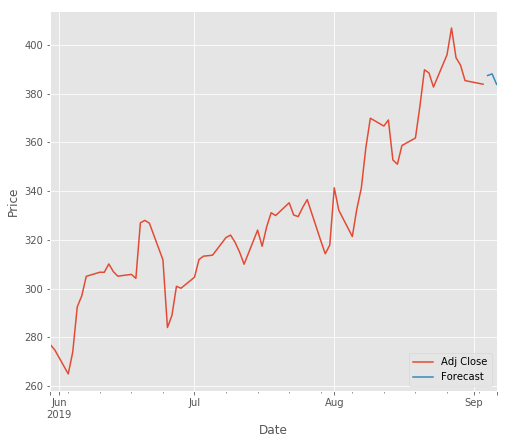

In [0]:
print("Enough with the code. Let's get that cheddar! 💰🧀")

clfreg_forecast = clfreg.predict(X_lately)
clfpoly2_forecast = clfpoly2.predict(X_lately)
clfpoly5_forecast = clfpoly5.predict(X_lately)
clfknn_forecast = clfknn.predict(X_lately)
forecast_set = (clfreg_forecast + clfpoly2_forecast + clfpoly5_forecast + clfknn_forecast) / 4

df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in
                         range(len(df.columns)-1)]+[i]

df['Adj Close'].tail(100).plot()
df['Forecast'].tail(100).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
isBuySignal = np.mean(forecast_set) > df.iloc[-forecast_set.size - 1]['Adj Close']

print('I think you should...')
print('BUY!' if isBuySignal else 'SELL!')

I think you should...
BUY!


In [0]:
# Extra Credit
# https://colab.research.google.com/drive/1FzLCI0AO3c7A4bp9Fi01UwXeoc7BN8sW#scrollTo=S8Q9zy5hY6CR

from collections import deque
import random

name = 'Double Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
import tensorflow as tf

df_full = pdr.get_data_yahoo("SHOP", start="2017-01-01").reset_index()
close = df_full['Close'].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 5438.450090.3, cost: 0.554053, total money: 7941.230165
epoch: 20, total rewards: 1450.599947.3, cost: 0.104391, total money: 6114.749970
epoch: 30, total rewards: 950.240059.3, cost: 0.055083, total money: 10564.850044
epoch: 40, total rewards: 4708.409954.3, cost: 0.146111, total money: 7840.589947
epoch: 50, total rewards: 246.269994.3, cost: 0.042269, total money: 9854.560003
epoch: 60, total rewards: 95.900081.3, cost: 0.011444, total money: 9309.390102
epoch: 70, total rewards: 377.569943.3, cost: 0.032290, total money: 10377.569943
epoch: 80, total rewards: 620.099994.3, cost: 0.108395, total money: 10245.129993
epoch: 90, total rewards: 124.170116.3, cost: 0.015916, total money: 9347.070110
epoch: 100, total rewards: 203.559984.3, cost: 0.022321, total money: 9811.849993
epoch: 110, total rewards: 200.689993.3, cost: 0.013823, total money: 9419.339987
epoch: 120, total rewards: 463.500018.3, cost: 0.019790, total money: 10463.500018
epoch: 130, total r

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 42.820000, total balance 9957.180000
day 1, sell 1 unit at price 44.139999, investment 3.082669 %, total balance 10001.319999,
day 10: buy 1 unit at price 49.980000, total balance 9951.339999
day 11, sell 1 unit at price 50.660000, investment 1.360544 %, total balance 10001.999999,
day 12: buy 1 unit at price 50.090000, total balance 9951.909999
day 13, sell 1 unit at price 49.439999, investment -1.297666 %, total balance 10001.349998,
day 46: buy 1 unit at price 64.150002, total balance 9937.199996
day 48, sell 1 unit at price 63.830002, investment -0.498831 %, total balance 10001.029998,
day 56: buy 1 unit at price 68.980003, total balance 9932.049995
day 57, sell 1 unit at price 70.400002, investment 2.058566 %, total balance 10002.449997,
day 103: buy 1 unit at price 93.440002, total balance 9909.009995
day 104, sell 1 unit at price 97.529999, investment 4.377137 %, total balance 10006.539994,
day 119: buy 1 unit at price 94.480003, total balance 9912.059

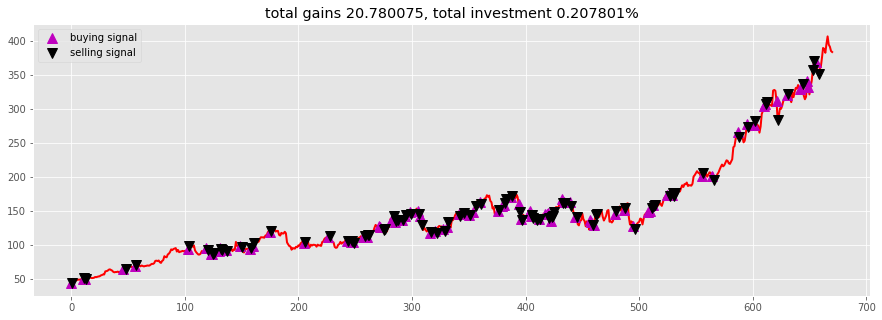

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

![Payday](https://media.giphy.com/media/C9ElAcAHIPvCmgRxJM/giphy.gif "Payday!")